In [1]:
"""
Initialization of data, info below!
"""

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import math
from check_solution import check_solution
data_url = r'bank_data.csv'
dataframe = pd.read_csv(data_url)

SPEED = 30.0
TOTAL_HOURS = 24

dataframe['dist_to_zero'] = np.sqrt((dataframe['x_coordinate']**2 + dataframe['y_coordinate']**2))
dataframe['time_to_zero'] = dataframe['dist_to_zero'] / SPEED
dataframe['greedy_stat_to_0'] = dataframe['money'] / (dataframe['time_to_zero'] + dataframe['time (hr)'])
dataframe['greedy_stat'] = dataframe['money'] / dataframe['time (hr)']

df = dataframe

# 'greedrank' is the val used to select the first bank
# assuming 0,0 is our t_list[0] position, greedrank[0] is the
# bank which our alg would select for t_list[1]
greedrank = df.sort_values(by=['greedy_stat_to_0'], ascending=False)

Hello Traveler,  
Welcome to my bank robbing algorithm(s)  
  
This system will attempt to construct  
a travel list in reverse, such that the first  
bank selected is the 'final' bank visited  
then building outwards, until ~24h has expired  
  
Initially calling a distance matrix, such that  
I can compare the distance from a given bank to  
all other available banks  
  
The result of the initial algorithm (the robber)  
will be passed to a secondary algorithm, which  
will attempt to reroute the input, such that   
additional time is made available  
  
This additional time will be passed back to  
the robber, who will attempt to add new banks  
to the travel list  

When this is no longer possible, the result is  
considered 'finished'  

In [2]:
"""
Distance Matrix init
"""
dist_mat = squareform(pdist(df[['x_coordinate', 'y_coordinate']]))

In [3]:
"""
Taken from solution check
"""

def distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)

def time_check(travel_list, df=df):
    t_rem = 24
    # if first bank isnt in [-1], flip
    if travel_list[-1] != greedrank.iloc[0].id:
        travel_list = travel_list[::-1]
        
    prev = travel_list[0]
    for e in travel_list:
        row = df.iloc[e]
        t_rem -= row['time (hr)']
        dist = distance(
            row['x_coordinate'], row['y_coordinate'],
            df.iloc[prev]['x_coordinate'],
            df.iloc[prev]['y_coordinate'],
        )
        t_rem -= dist / SPEED
        prev = e
        
    dist2 = distance(row['x_coordinate'],row['y_coordinate'],0,0)
    final_t = t_rem - (dist2 / SPEED)
    return final_t

In [4]:
"""
A greedy alrgorithm which...

Takes remaining time:
(if none provided, 24h)

Takes a Travel List:
(if none provided, starts one)

Adds banks to the list 
until no time remaining

Selection Criteria:
Money / (Work Time + Travel Time)
"""
def greedy_robber(t=TOTAL_HOURS, t_list=[]):
    #initialization
    c_list = t_list.copy()
    time = t
    if time <= 0:
        print("there's no time")
        return t_list
    if c_list == []:
        # if no banks in c_list
        # add greedrank[0] as first bank
        c_list.append(int(greedrank.iloc[0].id))
        
    while time > 0:
        # init all arrays
        travel = dist_mat[c_list[-1]] / SPEED
        work = df['time (hr)']
        money = df['money']
        ttz = df['time_to_zero']
        # combo arrays
        tot_time = work + travel
        act_time = ttz + tot_time
        # selection criteria
        sel_crit = ( money / tot_time )
        # bool mask for visited banks
        mask1 = np.zeros(len(travel), dtype=bool)
        mask1[c_list] = True
        # bool mask for banks where
        # there is time to get there
        # and back to 0,0 before 24h
        mask2 = act_time > time
        sel_crit[mask1] = -np.inf
        sel_crit[mask2] = -np.inf
        # next bank is highest avail
        next_bnk = sel_crit.argmax()
        
        if time - act_time[next_bnk] < 0:
            return c_list   
        else:
            c_list.append(next_bnk)
            time -= tot_time[next_bnk]
            
    return c_list

In [5]:
"""
A greedy routing algorithm

Takes:
An 'unrouted' list of banks

Returns:
A 'routed' list of banks based
on selection criteria

Selection Critieria: 
Travel Time / Time to Zero
"""

def route_bot(t_list):
    visited = []
    inp = t_list.copy()
    # start with original bank
    visited.append(int(greedrank.iloc[0].id))
    # clean origin bank out from inp
    inp.pop(inp.index(visited[-1]))

    while inp:
        # init arrays
        state = visited[-1]
        ttz = df['time_to_zero']
        travel = dist_mat[state] / SPEED
        # selection criteria
        sel_crit = travel / ttz
        # bool mask to elim
        # already choosen banks
        mask = np.zeros(len(travel), dtype=bool)
        mask[inp] = True
        sel_crit[~mask] = np.inf
        # next bank = argmin
        # of selection criteria
        next_bnk = sel_crit.argmin()
        # take ind of next bank 
        # pop it from inp, into visited
        visited.append(inp.pop(inp.index(next_bnk)))
        
    return visited

In [6]:
"""
Function used to cleanly perform the exchange
between Robber/Router algorithms

Input: A travel list
Output: A better/longer travel list
"""

def iterate(inp):
    t_list = inp
    time_rem = time_check(inp)
    out = greedy_robber(time_rem, t_list)
    out = route_bot(out)
    print('iterate results')
    print('init len: '+str(len(inp)))
    print('out len:  '+str(len(out)))
    print('init tim_rem: '+str(time_rem))
    print('out tim_rem:  '+str(time_check(out))+ '\n')
    return out

In [7]:
"""
This section will
run a series of passes

Where:
Output of Robber alg
is passed to Route alg,
and the output from Route
is returned

Until the output stops
improving upon prev
"""
# initialize
one = greedy_robber()
one_routed = route_bot(one)
# hardcoded iterations
two = iterate(one_routed)
three = iterate(two)
four = iterate(three)
five = iterate(four)
six = iterate(five)

iterate results
init len: 240
out len:  256
init tim_rem: 2.6772652165117297
out tim_rem:  0.5146552444580749

iterate results
init len: 256
out len:  261
init tim_rem: 0.5146552444580749
out tim_rem:  0.16828690641365895

iterate results
init len: 261
out len:  262
init tim_rem: 0.16828690641365895
out tim_rem:  0.1097854973570982

iterate results
init len: 262
out len:  263
init tim_rem: 0.1097854973570982
out tim_rem:  0.03385155582809672

iterate results
init len: 263
out len:  263
init tim_rem: 0.03385155582809672
out tim_rem:  0.03385155582809672



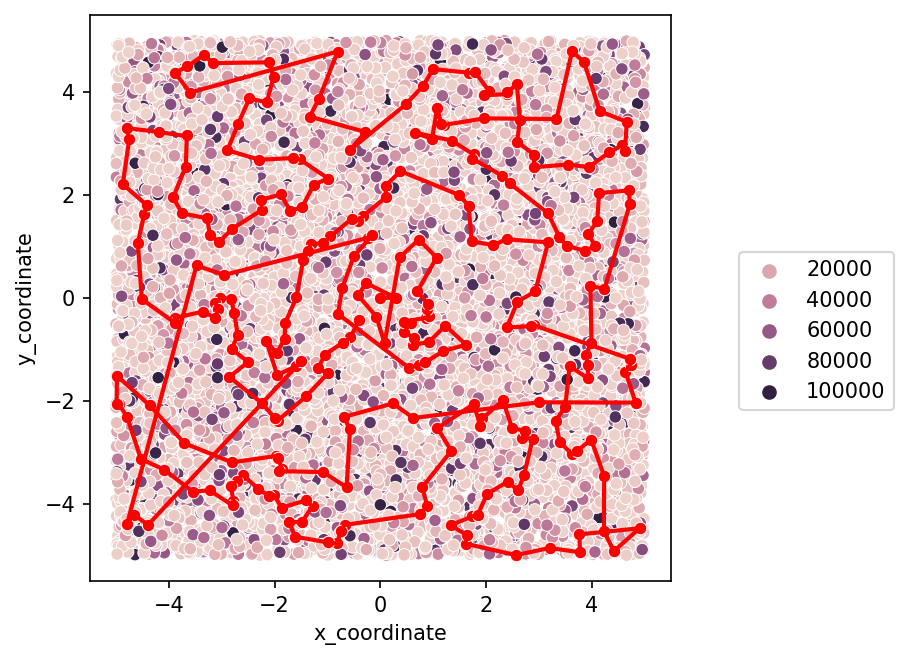

In [8]:
"""
Viz courtesy of Bruno
"""

import matplotlib.pyplot as plt
import seaborn as sns
path = six
plt.figure(dpi=150, figsize=(5,5))
sns.scatterplot(x='x_coordinate', y='y_coordinate', data=dataframe, hue='money')
x_arr = [df.loc[e].x_coordinate for e in path]
y_arr = [df.loc[e].y_coordinate for e in path]
x_arr.append(0)
y_arr.append(0)
sns.scatterplot(x=x_arr,y=y_arr,color='red',sizes=5)
sns.lineplot(x=x_arr,y=y_arr,lw=2,color='red',sizes=5,sort=False)
plt.legend(bbox_to_anchor=(1.1,0.6))

In [9]:
"""
Solution Check:
(Reverse lists before check, to account for alg orientation)
"""
check_solution(six[::-1], df, speed=30)

Time Remaining: 0.03385155582809672


15148400.0